
[Open in Colab](https://colab.research.google.com/drive/1sG4VUDZ80WdLo6ah9gjyXtWounrosG10?usp=sharing)


In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Loading Data Set

In [2]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
fetch_housing_data()

In [4]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

# Analysing The Data Structure

In [5]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


# ocean_proximity Values

In [7]:
housing["ocean_proximity"].value_counts()

,count
ocean_proximity,
<1H OCEAN,9136
INLAND,6551
NEAR OCEAN,2658
NEAR BAY,2290
ISLAND,5


# Create a Test Set

In [8]:
np.random.seed(42)

In [9]:
import numpy as np

# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [10]:
train_set, test_set = split_train_test(housing, 0.2)
len(train_set)

16512

In [11]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [12]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [13]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [15]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

,count
income_cat,
3,0.350533
2,0.318798
4,0.176357
5,0.114341
1,0.039971


In [16]:
housing["income_cat"].value_counts() / len(housing)

,count
income_cat,
3,0.350581
2,0.318847
4,0.176308
5,0.114438
1,0.039826


In [17]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [18]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


# Prepareing the Data

## Data Cleaning

In [19]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

In [20]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,NaN,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,NaN,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,NaN,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,NaN,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,NaN,1145.0,480.0,6.3580,NEAR OCEAN




```
sample_incomplete_rows.dropna(subset=["total_bedrooms"])    # option 1
sample_incomplete_rows.drop("total_bedrooms", axis=1)       # option 2
```



In [21]:
#we use option 3
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # option 3
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,433.0,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,433.0,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,433.0,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,433.0,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,433.0,1145.0,480.0,6.3580,NEAR OCEAN


In [22]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

Remove the text attribute

In [23]:
housing_num = housing.drop("ocean_proximity", axis=1)


In [24]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [25]:
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [26]:
housing_num.median().values #Check that this is the same as manually computing the median of each attribute:

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

## Transform the training set:

In [27]:
X = imputer.transform(housing_num)

In [28]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing.index)

In [29]:
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
1606,-122.08,37.88,26.0,2947.0,433.0,825.0,626.0,2.9330
10915,-117.87,33.73,45.0,2264.0,433.0,1970.0,499.0,3.4193
19150,-122.70,38.35,14.0,2313.0,433.0,954.0,397.0,3.7813
4186,-118.23,34.13,48.0,1308.0,433.0,835.0,294.0,4.2891
16885,-122.40,37.58,26.0,3281.0,433.0,1145.0,480.0,6.3580


In [30]:
imputer.strategy

'median'

In [31]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

In [32]:
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964


## Handling Text and Categorical Attributes

### Preprocess the categorical input feature, ocean_proximity:

In [33]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


In [34]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [35]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [36]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [37]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [38]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

## Transformation Pipelines for Preprocessing the Numerical Attributes:

In [39]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),

        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [40]:
housing_num_tr

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.73260236,
         0.55628602, -0.8936472 ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.53361152,
         0.72131799,  1.292168  ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ..., -0.67467519,
        -0.52440722, -0.52543365],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ..., -0.86201341,
        -0.86511838, -0.36547546],
       [-1.56080303,  1.2492109 , -1.1653327 , ..., -0.18974707,
         0.01061579,  0.16826095],
       [-1.28105026,  2.02567448, -0.13148926, ..., -0.71232211,
        -0.79857323, -0.390569  ]])

In [41]:
#Full pipeline combining numerical and categorical features

from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),  # Apply numerical transformations
        ("cat", OneHotEncoder(), cat_attribs), # Apply OneHotEncoder to categorical feature
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [42]:
housing_prepared

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

In [43]:
housing_prepared.shape

(16512, 13)

In [53]:


def display_scores(scores): # define the function display_scores
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(forest_rmse_scores)

Scores: [51039.08053738 48741.94041426 45940.42771745 50501.41453432
 47387.7896427  49595.25845731 51625.68567717 48865.70709952
 47322.87631489 53301.08748462]
Mean: 49432.12678796127
Standard deviation: 2124.8587921578355


# Model 1 Training: Linear Regression

In [54]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [55]:
# let's try the full preprocessing pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [ 88983.14806384 305351.35385026 153334.71183453 184302.55162102
 246840.18988841]


In [56]:
print("Labels:", list(some_labels))  #compare with actual values

Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


### Root Mean Squared Error: Linear Regression

In [57]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

69050.56219504567

### Mean Absolute Error: Linear Regression

In [58]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49905.329442715316

### Cross Validation: Linear Regression

In [59]:
from sklearn.model_selection import cross_val_score

lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [72229.03469752 65318.2240289  67706.39604745 69368.53738998
 66767.61061621 73003.75273869 70522.24414582 69440.77896541
 66930.32945876 70756.31946074]
Mean: 69204.32275494763
Standard deviation: 2372.070791055922


In [60]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

,0
count,10.000000
mean,69204.322755
std,2500.382157
min,65318.224029
25%,67124.346106
50%,69404.658178
75%,70697.800632
max,73003.752739


# Model 2 Training: Random Forest Regressor

In [61]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(random_state=42)

### Root Mean Squared Error: Random Forest Regressor

In [62]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18342.366362322846

### Mean Absolute Error: Random Forest Regressor

In [63]:
from sklearn.metrics import mean_absolute_error

forest_mae = mean_absolute_error(housing_labels, housing_predictions)
forest_mae

11813.920286458333

### Cross Validation: Random Forest Regressor

In [64]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(random_state=42)

In [65]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18342.366362322846

In [66]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [51039.08053738 48741.94041426 45940.42771745 50501.41453432
 47387.7896427  49595.25845731 51625.68567717 48865.70709952
 47322.87631489 53301.08748462]
Mean: 49432.12678796127
Standard deviation: 2124.8587921578355


In [67]:
scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

,0
count,10.000000
mean,49432.126788
std,2239.797830
min,45940.427717
25%,47726.327336
50%,49230.482778
75%,50904.664037
max,53301.087485


# Model 3 Training: Decision Tree Regressor

In [68]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(random_state=42)

### Root Mean Squared Error: Decision Tree Regressor

In [69]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

### Mean Absolute Error: Decision Tree Regressor

In [70]:
from sklearn.metrics import mean_absolute_error

tree_mae = mean_absolute_error(housing_labels, housing_predictions)
tree_mae

0.0

### Cross Validation: Decision Tree Regressor

In [71]:
from sklearn.model_selection import cross_val_score

tree_scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)
display_scores(tree_rmse_scores)

Scores: [71177.6601991  69770.07865373 64770.5639395  68536.60203993
 67057.08155801 68847.12456973 70977.38255647 69208.86346929
 67187.87131535 73280.38732407]
Mean: 69081.361562518
Standard deviation: 2296.288087393378


In [72]:
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

,0
count,10.000000
mean,69081.361563
std,2420.500173
min,64770.563939
25%,67525.053996
50%,69027.994020
75%,70675.556581
max,73280.387324


# Model 4 Training: Support Vector Machine Regressor (SVR)

In [73]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)

SVR(kernel='linear')

### Root Mean Squared Error: SVR

In [74]:
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

111802.67909771342

### Mean Absolute Error: SVR

In [75]:
from sklearn.metrics import mean_absolute_error

svm_mae = mean_absolute_error(housing_labels, housing_predictions)
svm_mae

82276.56523050081

### Cross Validation: SVR

In [76]:
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
svm_rmse_scores = np.sqrt(-svm_scores)
display_scores(svm_rmse_scores)

Scores: [111059.94607445 113687.87132915 107597.3277054  114213.41574463
 108461.30158859 116616.25904798 113850.21483718 112395.74942581
 113807.23691329 112686.31474177]
Mean: 112437.56374082548
Standard deviation: 2593.2605559090666


In [77]:
scores = cross_val_score(svm_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

,0
count,10.000000
mean,112437.563741
std,2733.536641
min,107597.327705
25%,111393.896912
50%,113187.093035
75%,113839.470356
max,116616.259048


###########################################################

## RMSE Comparison Plot:

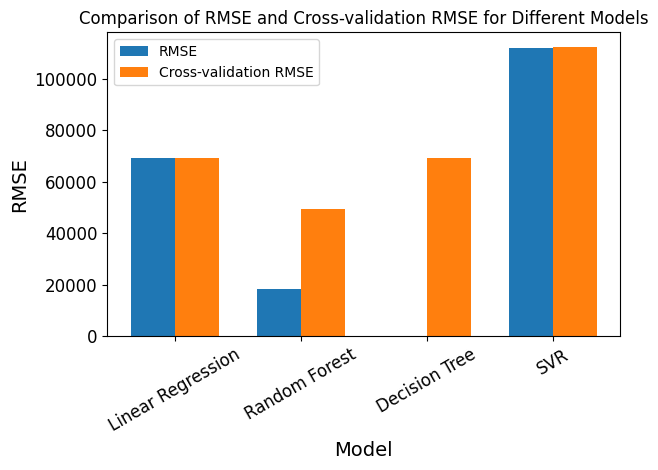

In [78]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
models = ['Linear Regression', 'Random Forest', 'Decision Tree', 'SVR']
rmse = [69050.56, 18342.37, 0, 111802.68]
cv_rmse = [69204.32, 49432.13, 69081.36, 112437.56]

# Plot RMSE and Cross-validation RMSE
bar_width = 0.35
index = np.arange(len(models))

plt.bar(index, rmse, bar_width, label='RMSE')
plt.bar(index + bar_width, cv_rmse, bar_width, label='Cross-validation RMSE')

# Labels and titles
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('Comparison of RMSE and Cross-validation RMSE for Different Models')
plt.xticks(index + bar_width / 2, models, rotation=30)
plt.legend()

plt.tight_layout()
plt.show()


# SVR with with various hyperparameters

Experimenting SVR (sklearn.svm.SVR) with `kernel="linear"` and `kernel="rbf"` hyperparameters




In [58]:
from sklearn.model_selection import GridSearchCV

param_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END ..............................C=10.0, kernel=linear; total time=  11.6s
[CV] END ..............................C=10.0, kernel=linear; total time=  11.6s
[CV] END ..............................C=10.0, kernel=linear; total time=  11.5s
[CV] END ..............................C=10.0, kernel=linear; total time=  11.5s
[CV] END ..............................C=10.0, kernel=linear; total time=  10.3s
[CV] END ..............................C=30.0, kernel=linear; total time=  11.0s
[CV] END ..............................C=30.0, kernel=linear; total time=  11.5s
[CV] END ..............................C=30.0, kernel=linear; total time=  11.5s
[CV] END ..............................C=30.0, kernel=linear; total time=  11.5s
[CV] END ..............................C=30.0, kernel=linear; total time=  10.5s
[CV] END .............................C=100.0, kernel=linear; total time=  10.6s
[CV] END .............................C=100.0, 

GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0,
                                10000.0, 30000.0],
                          'kernel': ['linear']},
                         {'C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0],
                          'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
                          'kernel': ['rbf']}],
             scoring='neg_mean_squared_error', verbose=2)

In [59]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

70444.58358729436

In [60]:
grid_search.best_params_  #check the best hyperparameters found:

{'C': 30000.0, 'kernel': 'linear'}